# MCT4052 Workshop 8b: Tensorflow-Keras ANN Regressor

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

This notebook shows how to train, test and use an ANN for regression in tensorflow. We use the same dataset used in earlier Workshops.

### 1. Importing Tensorflow and Keras


In [1]:
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
import IPython.display as Ipd
import os
import sklearn
import scipy
import datetime

%matplotlib inline
%config IPCompleter.greedy=True

# Import TensorFlow and Keras
import tensorflow as tf

# display tensorflow version (this notwbook was developed with 2.7)
print(tf.__version__)

2.7.0


### 2. Computing features, targets and splitting the dataset

This time we store the features in an numpy array of matrices (i.e. a 3D array) ad tensorflow is able to "flatten" the data internally (is instructed to do so).

In [2]:
sr = 44100

def lin_interp_2d(data, out_size):
    
    x_in_size = data.shape[1]
    y_in_size = data.shape[0]
    x_in = np.arange(0,x_in_size)
    y_in = np.arange(0,y_in_size)
    interpolator = scipy.interpolate.interp2d(x_in, y_in, data, kind='linear')
    x_out = np.arange(0,x_in_size-1,((x_in_size-1)/out_size[1]))
    y_out = np.arange(0,y_in_size-1,((y_in_size-1)/out_size[0]))
    output = interpolator(x_out, y_out)
    output = output[0:out_size[0],0:out_size[1]]
    
    return output

def extract_features_targets(filename, sr):
    
    signal, dummy = librosa.load(filename, sr, mono=True)
    
    features = librosa.feature.melspectrogram(signal, n_mels=32)
    
    features = lin_interp_2d(features, (32,16)) # scaling to identical lenght
    
    targets = np.zeros((1,2))
    targets[0,0] = np.mean(librosa.feature.spectral_centroid(signal))
    targets[0,1] = np.mean(librosa.feature.spectral_flatness(signal))
    
    return features, targets

filenames = os.listdir('./data/examples2')
features = np.zeros((len(filenames),32,16)) #3D Numpy array to store MFCC computed e changed if using more or less features)
targets = np.zeros((len(filenames),2))

for i in range(len(filenames)):
    features[i,:,:], targets[i,:] = extract_features_targets('./data/examples2/'+filenames[i], sr) # alternative features[i,:,:]


print('Done!')

Done!


In [3]:
# for the splitting we still use scikit learn

from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, tar_train, tar_test = train_test_split(features, targets, test_size=0.2)

### 3. Defining, compiling, training and using the ANN

Compared to the previous notebook, setting an appropriate loss function (related to the error) is a key element to train a regression model

In [4]:
# building the model, the input layer must match the input data
# for regression we need an output for each target value
# here we also integrate a normalization layer (not an absolute must)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 16)),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dense(2, activation='relu')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 512)               0         
                                                                 
 normalization (Normalizatio  (None, 512)              1025      
 n)                                                              
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 6,177
Trainable params: 5,152
Non-trainable params: 1,025
_________________________________________________________________


2022-03-16 10:51:59.422331: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# setting loss function and metric
# we also specify the learning rate, which needs to be further
# adjusted to speed up the training

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [6]:
# fitting the model and setting some parameters

history = model.fit(
    feat_train,
    tar_train,
    batch_size=32,
    epochs=100,
    validation_split = 0.1
)

Epoch 1/100
4/4 [==============================] - 1s 40ms/step - loss: 895.0866 - val_loss: 988.7939
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 893.0769 - val_loss: 986.8344
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 891.2676 - val_loss: 984.9223
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 889.3126 - val_loss: 982.8414
Epoch 5/100
4/4 [==============================] - 0s 7ms/step - loss: 887.1838 - val_loss: 980.6893
Epoch 6/100
4/4 [==============================] - 0s 6ms/step - loss: 885.1140 - val_loss: 978.6151
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 883.0445 - val_loss: 976.5308
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 880.9818 - val_loss: 974.4459
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 878.9299 - val_loss: 972.3585
Epoch 10/100
4/4 [==============================] - 0s 7ms/step - loss: 876.8752 - val_los

4/4 [==============================] - 0s 6ms/step - loss: 721.6008 - val_loss: 810.2823
Epoch 82/100
4/4 [==============================] - 0s 7ms/step - loss: 719.4889 - val_loss: 808.0604
Epoch 83/100
4/4 [==============================] - 0s 7ms/step - loss: 717.3740 - val_loss: 805.8343
Epoch 84/100
4/4 [==============================] - 0s 6ms/step - loss: 715.2760 - val_loss: 803.5985
Epoch 85/100
4/4 [==============================] - 0s 7ms/step - loss: 713.1581 - val_loss: 801.6215
Epoch 86/100
4/4 [==============================] - 0s 7ms/step - loss: 711.0316 - val_loss: 799.7108
Epoch 87/100
4/4 [==============================] - 0s 7ms/step - loss: 708.8998 - val_loss: 797.8075
Epoch 88/100
4/4 [==============================] - 0s 8ms/step - loss: 706.8069 - val_loss: 795.8995
Epoch 89/100
4/4 [==============================] - 0s 7ms/step - loss: 704.6815 - val_loss: 794.1351
Epoch 90/100
4/4 [==============================] - 0s 7ms/step - loss: 702.5958 - val_loss: 79

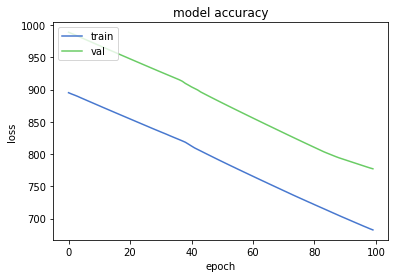

In [7]:
# plotting validation and train loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
# evaluating performance on test set
# tensorflow provides  many error-related metrics
# but it does not provide the R2 score (we have to manually define a function for it)

def R_squared(y, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

tar_pred = model.predict(feat_test)

print('R Squared', R_squared(tar_test, tar_pred))

R Squared tf.Tensor(-0.0260275885121255, shape=(), dtype=float64)


### 4. Follow up activities

1. Try to improve performances (with the current settings is evident that the training is incomplete).